<a href="https://colab.research.google.com/github/Lidiya-cutie/WineEnthusiastAnalysis/blob/master/WineEnthusiast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bинные обзоры

+ country - страна-производитель вина
+ description - подробное описание
+ designation - название виноградника, где выращивают виноград для вина
+ points - количество баллов, которое WineEnthusiast оценил вино по шкале от 1 до 100
+ price - стоимость бутылки вина
+ province - провинция или штат 
+ region_1 - винодельческий район в провинции или штате (например, Напа)
+ region_2 - конкретный регион. Иногда в пределах винодельческой зоны указываются более конкретные регионы (например, Резерфорд в долине Напа), но это значение иногда может быть пустым.
+ taster_name - имя дегустатора
+ taster_twitter_handle - твиттер дегустатора
+ title - название вина, который часто содержит годи др подробную информацию
+ variety -  сорт винограда, из которого изготовлено вино (например, Пино Нуар).
+ winery - винодельня, которая производила вино

## Знакомство с данными 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Импортируем необходимую библиотеку:
import pandas as pd
# Прочитаем наш файл с винными обзорами:
data = pd.read_csv('/content/wine.csv')

Составим чек-лист всех этапов жизненного цикла модели машинного обучения для создания ИИ-сомелье. Подробно раскроем процесс разведывательного анализа данных с подэтапами.

* Определение бизнес-проблемы
* Сбор данных
* Очистка данных от пропусков/выбросов/аномалий
* Разведывательный анализ данных
    + проектирование признаков (генерация из внешних источников данных, из признаков датасета)
    + кодирование признаков
    + проверка статистических гипотез
    + отбор признаков
* Разработка модели
* Вывод модели в продакшн

Для начала узнаем, сколько всего дегустаторов приняло участие в винных обзорах. Чтобы правильно подсчитать количество дегустаторов, воспользуйтесь функцией *nunique()* применительно к столбцу *'taster_name'*..

In [ ]:
data['taster_name'].nunique()
# 19

19

Узнаем, какова максимальная цена за бутылку в этом наборе данных. Для этого воспользуемся функцией *max()* применительно к столбцу *'price'*.

In [ ]:
data['price'].max()
# 3300

3300.0

Проанализируем представленный датасет и перечислим все числовые признаки через запятую.

In [ ]:
data.describe()
# points, price

array([[<Axes: title={'center': 'points'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

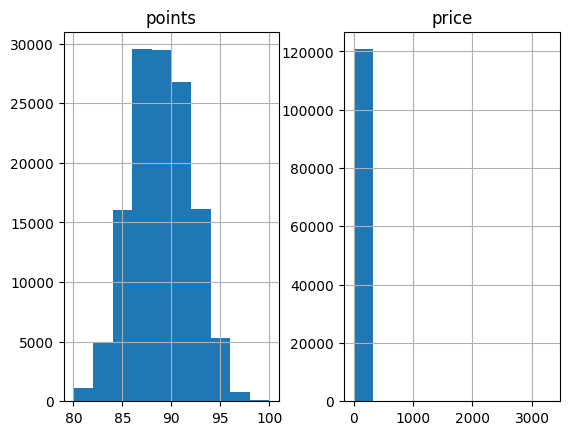

In [ ]:
# построим распеределение всех возможных признаков быстрой просто визуализацией
hist = data.hist()
hist

Проанализируем датасет на наличие дублирующихся винных обзоров. Если дублирующиеся записи есть, удалим их.
Посмотримб сколько дублирующихся записей удалось обнаружить. Для этого воспользуемся duplicated().count() и data.drop_duplicates().count().max() и вычислим разницу.

In [ ]:
drop_count = data.duplicated().count() - data.drop_duplicates().count().max()
print(f'Число найденных дубликатов: {drop_count}')
# Число найденных дубликатов: 9983

Число найденных дубликатов: 9983


или другим способом

In [ ]:
mask = data.duplicated(subset=data.columns) # маска для фильтрации
data_duplicates = data[mask] # фильтруем наш датасет
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 9983


Проверяем датасет на наличие пропусков в данных. Узнаем, в каких из представленных признаках были обнаружены пропуски

In [ ]:
data.info()
# designation, price, region_2, taster_twitter_handle - были обнаружены пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


Обработаем пропущенные значения в наборе данных. Импортируем библиотеки, которые нам понадобятся (pandas для работы с данными, numpy для математических преобразований, matplotlib и seaborn для визуализации).
* Если какой-то из признаков имеет более 30-40 % пропусков, лучше избавиться от него: его заполнение может привести к сильному искажению общего распределения, а удаление записей — к большой утрате данных.
* Заполним данные с умом! Если в данных количественный признак, то использование нецелого числа в качестве константы является как минимум нелогичным.
* Можно оставить пропуски как есть, просто заменив их на какой-то специальный символ. Например, для числовых неотрицательных признаков можно использовать число -1, а для категориальных — строку 'unknown'.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

В библиотеке *pandas* специально для этого реализован метод *isnull()*. Этот метод возвращает новый *DataFrame*, в ячейках которого стоят булевы значения *True* и *False*. *True* ставится на месте, где ранее находилось значение *NaN*.

Посмотрим на результат работы метода на нашей таблице:

In [ ]:
data.isnull()
# ячейки со значением True
# ячейки, где стоит False, были изначально заполнены.

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,False,False,False,False,True,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,True,True,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,False,False,False,False,False,False,True,True,False,True,False,False,False
129967,False,False,True,False,False,False,False,False,False,False,False,False,False
129968,False,False,False,False,False,False,False,True,False,False,False,False,False
129969,False,False,True,False,False,False,False,True,False,False,False,False,False


Выводим на экран названия столбцов, где число пропусков больше 0. 

Для этого вычислим средний по столбцам результат метода *isnull()*. Получим долю пропусков в каждом столбце.

*True* — 1, *False* — 0, при расчёте среднего получим долю 1 от общего числа строк. 
Умножаем на 100 %, находим **столбцы**, где доля пропусков больше 0, сортируем по убыванию и выводим результат:

Посмотрим на число записей:

In [ ]:
data.shape

(129971, 13)

In [ ]:
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0.0000].sort_values(ascending=False)
cols_null_percent

country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64

Итак, можно увидеть, что у нас большое число пропусков (более 61 %) в столбце *region_2* (конкретный регион в пределах винодельческой зоны). 

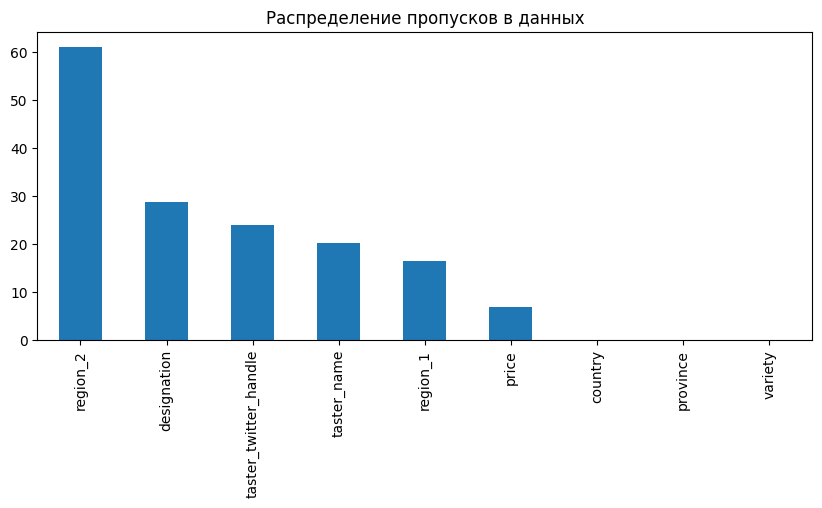

In [ ]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

* Удаляем столбцы с числом пропусков более 30 %.
* Удаляем записи, в которых более двух пропусков одновременно.
* Заполним пропуски.

In [ ]:
# оздаём копию исходной таблицы
drop_data = data.copy()
# число строк в таблице
count = drop_data.shape[0]
# отбрасываем столбцы с числом пропусков более 30% (100-70)
min_drop = count * 0.7
drop_data = drop_data.dropna(thresh=min_drop, axis=1)
# число строк в таблице, где пропусков более 2-х в строке
drop_two = drop_data.shape[1]
# число признаков после удаления столбцов
drop_data = drop_data.dropna(thresh=drop_two-2, axis=0)
# создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'country': drop_data['country'].fillna('US'),
    'variety': drop_data['variety'].fillna('Pinot Noir'),
    'regiion_2': 'unknown',
    'designation': 'unknown',
    'taster_twitter_handle': 'unknown',
    'province': drop_data['province'].fillna('California'),
    'region_1': 'unknown',
    'taster_name': 'unknown',
    'price': round(drop_data['price'].mean())
}
# заполняем пропуски в соответствии с заявленным словарем
drop_data = drop_data.fillna(values)
drop_data.isnull().mean()

country                  0.0
description              0.0
designation              0.0
points                   0.0
price                    0.0
province                 0.0
region_1                 0.0
taster_name              0.0
taster_twitter_handle    0.0
title                    0.0
variety                  0.0
winery                   0.0
dtype: float64

In [ ]:
# Посмотрим на результирующее число записей:
drop_data.shape

(119230, 12)

<Axes: >

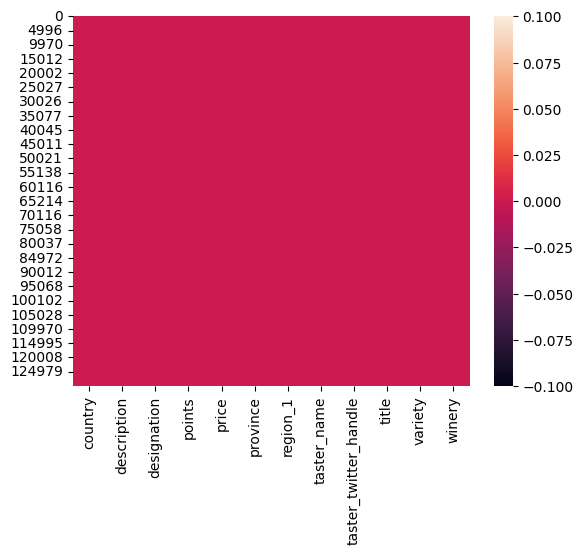

In [ ]:
# Убеждаемся, что датасет без пропусков
sns.heatmap(drop_data.isnull()) 

In [ ]:
# сохраняем очищенный датасет для дальнейшей работы
df = drop_data.to_csv('wine_cleared.csv', index=False) 